# Import packages

In [74]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import stats
from scipy.stats import zscore
import seaborn as sns
import yfinance as yf
from sklearn import model_selection
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson

# Get list of S&P 500 stocks

In [2]:
# Get the list of S&P 500 stocks
sp500_stocks = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()
print(sp500_stocks)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADM', 'ADBE', 'ADP', 'AES', 'AFL', 'A', 'ABNB', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BG', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CM

In [83]:
# Set the start date and end date of previous data
date_today = str(datetime.date.today())
date_from_2_years = str(datetime.date.today() - datetime.timedelta(days=2*365))
date_yesterday = str(datetime.date.today() - datetime.timedelta(days=1))

# Get Historical Technical Data

In [4]:
# Loop through the first 5 tickers and get historical data
technical_df = pd.DataFrame()
for stock in sp500_stocks:
    try:
        # Get historical data for the current ticker from the past 2 years
        stock_historical_data = yf.download(stock, start=date_from_2_years, end=date_today, progress=False)
        # Add a new column for the stock symbol
        stock_historical_data['Symbol'] = stock
        technical_df = pd.concat([technical_df, stock_historical_data])
    except Exception as e:
        print(f"Error retrieving data for {stock}: {e}")


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
C:\Users\Adham\AppData\Local\Temp\ipykernel_17608\2646852833.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  technical_df = pd.concat([technical_df, stock_historical_data])

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-10-27 -> 2023-10-27)')
C:\Users\Adham\AppData\Local\Temp\ipykernel_17608\2646852833.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  technical_df = pd.concat([technical_df, stock_h

In [5]:
print(len(technical_df))

250730


In [6]:
# Display the dataframe without breaking in separate line
pd.set_option('display.expand_frame_repr', False)

In [7]:
# Make "Date" a normal column instead of index as it has duplicates.
technical_df = technical_df.reset_index()

In [8]:
print(technical_df.tail())

             Date        Open        High         Low       Close   Adj Close     Volume Symbol
250725 2023-10-20  167.619995  168.259995  165.089996  167.089996  167.089996  1932000.0    ZTS
250726 2023-10-23  166.580002  168.580002  166.009995  166.500000  166.500000  1075400.0    ZTS
250727 2023-10-24  166.630005  168.240005  166.250000  167.119995  167.119995  1201400.0    ZTS
250728 2023-10-25  165.559998  165.990005  162.350006  163.669998  163.669998  1273600.0    ZTS
250729 2023-10-26  162.270004  162.289993  157.880005  158.070007  158.070007  2891100.0    ZTS


In [9]:
print(technical_df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Symbol'],
      dtype='object')


# Get Yesterday's Technical Data

In [84]:
yesterday_technical_df = pd.DataFrame()
for stock in sp500_stocks:
    try:
        # Download technical data for yesterday
        data = yf.download(stock, start=date_yesterday, end=date_today, progress=False)
        data['Symbol'] = stock
        yesterday_technical_df = pd.concat([yesterday_technical_df, data])
    except Exception as e:
        print(f"Error retrieving data for {stock}: {e}")


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
C:\Users\Adham\AppData\Local\Temp\ipykernel_17608\2924660089.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  yesterday_technical_df = pd.concat([yesterday_technical_df, data])

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-10-27 -> 2023-10-28)')
C:\Users\Adham\AppData\Local\Temp\ipykernel_17608\2924660089.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  yesterday_technical_df = pd.concat([yesterda

In [119]:
yesterday_technical_df.reset_index(inplace=True)

In [85]:
print(len(yesterday_technical_df))

501


In [120]:
print(yesterday_technical_df.tail())

          Date        Open        High         Low       Close   Adj Close     Volume Symbol
496 2023-10-27  119.040001  120.250000  118.279999  119.440002  119.440002  2330633.0    YUM
497 2023-10-27  204.600006  207.559998  201.160004  207.179993  207.179993   565000.0   ZBRA
498 2023-10-27  104.000000  104.809998  102.709999  103.190002  103.190002  1534500.0    ZBH
499 2023-10-27   30.590000   30.670000   28.980000   29.450001   29.450001  2498300.0   ZION
500 2023-10-27  157.929993  157.932007  155.160004  156.029999  156.029999  2406212.0    ZTS


# Get Historical Fundamental Data

In [10]:
selected_income_statement_columns = ['Basic EPS', 'Net Income', 'Total Revenue', 'Total Expenses']
selected_balance_sheet_columns = ['Total Debt', 'Total Capitalization', 'Total Assets']
selected_cash_flow_columns = ['Free Cash Flow', 'Capital Expenditure']

In [11]:
fundamental_df = pd.DataFrame()
for stock in sp500_stocks:
    try:
        stock_ticker = yf.Ticker(stock)
        # Get quarterly income statement
        quarterly_income_statement = stock_ticker.quarterly_incomestmt.transpose()
        # Get quarterly balance sheet
        quarterly_balance_sheet = stock_ticker.quarterly_balance_sheet.transpose()
        # Get quarterly cash flow
        quarterly_cash_flow = stock_ticker.quarterly_cashflow.transpose()
        # Merge the different fundamental data sources
        stock_fundamental_data = pd.merge(quarterly_income_statement[selected_income_statement_columns], quarterly_balance_sheet[selected_balance_sheet_columns], left_index=True, right_index=True)
        stock_fundamental_data = pd.merge(stock_fundamental_data, quarterly_cash_flow[selected_cash_flow_columns], left_index=True, right_index=True)
        # Add a new column for the stock symbol
        stock_fundamental_data['Symbol'] = stock
        stock_fundamental_data = stock_fundamental_data.resample('D').ffill()
        stock_fundamental_data = stock_fundamental_data[(stock_fundamental_data.index >= date_from_2_years) & (stock_fundamental_data.index <= date_today)]
        fundamental_df = pd.concat([fundamental_df, stock_fundamental_data])
    except Exception as e:
        print(f"Error retrieving data for {stock}: {e}")

Error retrieving data for AFL: "['Capital Expenditure'] not in index"
Error retrieving data for ARE: "['Capital Expenditure'] not in index"
Error retrieving data for LNT: "['Capital Expenditure'] not in index"
Error retrieving data for AXP: "['Total Expenses'] not in index"
Error retrieving data for AIG: "['Capital Expenditure'] not in index"
Error retrieving data for BAC: "['Total Expenses'] not in index"
Error retrieving data for BRK.B: "None of [Index(['Basic EPS', 'Net Income', 'Total Revenue', 'Total Expenses'], dtype='object')] are in the [columns]"
Error retrieving data for BX: "['Total Expenses'] not in index"
Error retrieving data for BK: "['Total Expenses'] not in index"
Error retrieving data for BXP: "['Capital Expenditure'] not in index"
Error retrieving data for BF.B: "None of [Index(['Basic EPS', 'Net Income', 'Total Revenue', 'Total Expenses'], dtype='object')] are in the [columns]"
Error retrieving data for COF: "['Total Expenses'] not in index"
Error retrieving data fo

In [12]:
print(len(fundamental_df))

139944


In [13]:
# Rename index to be "Date" then convert it to a normal column as it has duplicates
fundamental_df.reset_index(inplace=True)
fundamental_df.rename(columns={'index': 'Date'}, inplace=True)
fundamental_df['Date'] = pd.to_datetime(fundamental_df['Date'])

In [14]:
print(fundamental_df.tail())

             Date Basic EPS   Net Income Total Revenue Total Expenses    Total Debt Total Capitalization   Total Assets Free Cash Flow Capital Expenditure Symbol
139939 2023-06-26      1.19  552000000.0  2000000000.0   1272000000.0  6742000000.0        11053000000.0  13754000000.0    326000000.0        -223000000.0    ZTS
139940 2023-06-27      1.19  552000000.0  2000000000.0   1272000000.0  6742000000.0        11053000000.0  13754000000.0    326000000.0        -223000000.0    ZTS
139941 2023-06-28      1.19  552000000.0  2000000000.0   1272000000.0  6742000000.0        11053000000.0  13754000000.0    326000000.0        -223000000.0    ZTS
139942 2023-06-29      1.19  552000000.0  2000000000.0   1272000000.0  6742000000.0        11053000000.0  13754000000.0    326000000.0        -223000000.0    ZTS
139943 2023-06-30      1.45  671000000.0  2180000000.0   1346000000.0  6745000000.0        11180000000.0  13749000000.0     17000000.0        -166000000.0    ZTS


# Get Yesterday's Fundamental Data

In [121]:
yesterday_fundamental_df = pd.DataFrame()
for stock in sp500_stocks:
    try:
        stock_ticker = yf.Ticker(stock)
        # Get quarterly income statement
        quarterly_income_statement = stock_ticker.quarterly_incomestmt.transpose().head(1)
        # Get quarterly balance sheet
        quarterly_balance_sheet = stock_ticker.quarterly_balance_sheet.transpose().head(1)
        # Get quarterly cash flow
        quarterly_cash_flow = stock_ticker.quarterly_cashflow.transpose().head(1)
        # Merge the different fundamental data sources
        data = pd.merge(quarterly_income_statement[selected_income_statement_columns], quarterly_balance_sheet[selected_balance_sheet_columns], left_index=True, right_index=True)
        data = pd.merge(data, quarterly_cash_flow[selected_cash_flow_columns], left_index=True, right_index=True)
        # Add a new column for the stock symbol
        data['Symbol'] = stock
        data['Date'] = date_yesterday
        # Concat to the final dataframe
        yesterday_fundamental_df = pd.concat([yesterday_fundamental_df, data])
    except Exception as e:
        print(f"Error retrieving data for {stock}: {e}")

yesterday_fundamental_df.reset_index(inplace=True, drop=True)

Error retrieving data for AFL: "['Capital Expenditure'] not in index"
Error retrieving data for ARE: "['Capital Expenditure'] not in index"
Error retrieving data for LNT: "['Capital Expenditure'] not in index"
Error retrieving data for AXP: "['Total Expenses'] not in index"
Error retrieving data for AIG: "['Capital Expenditure'] not in index"
Error retrieving data for BAC: "['Total Expenses'] not in index"
Error retrieving data for BRK.B: "None of [Index(['Basic EPS', 'Net Income', 'Total Revenue', 'Total Expenses'], dtype='object')] are in the [columns]"
Error retrieving data for BX: "['Total Expenses'] not in index"
Error retrieving data for BK: "['Total Expenses'] not in index"
Error retrieving data for BXP: "['Capital Expenditure'] not in index"
Error retrieving data for BF.B: "None of [Index(['Basic EPS', 'Net Income', 'Total Revenue', 'Total Expenses'], dtype='object')] are in the [columns]"
Error retrieving data for COF: "['Total Expenses'] not in index"
Error retrieving data fo

In [122]:
print(len(yesterday_fundamental_df))

428


In [123]:
print(yesterday_fundamental_df.tail())

    Basic EPS   Net Income Total Revenue Total Expenses     Total Debt Total Capitalization   Total Assets Free Cash Flow Capital Expenditure Symbol        Date
423      0.45   92000000.0  1722000000.0   1575000000.0   2267000000.0        12166000000.0  16097000000.0    -26000000.0         -54000000.0    XYL  2023-10-27
424      1.49  418000000.0  1687000000.0   1125000000.0  11568000000.0         2758000000.0   5848000000.0    264000000.0         -60000000.0    YUM  2023-10-27
425       2.8  144000000.0  1214000000.0   1004000000.0   2365000000.0         5034000000.0   7456000000.0    -52000000.0         -18000000.0   ZBRA  2023-10-27
426       1.0  209600000.0  1869600000.0   1507600000.0   5709400000.0        17568000000.0  21294300000.0    177300000.0        -170600000.0    ZBH  2023-10-27
427      1.45  671000000.0  2180000000.0   1346000000.0   6745000000.0        11180000000.0  13749000000.0     17000000.0        -166000000.0    ZTS  2023-10-27


# Merge Technical and Fundamental Data

In [15]:
sp500_df = pd.merge(technical_df, fundamental_df, on=["Date", "Symbol"])

In [16]:
# Set index to a combination of Date
sp500_df = sp500_df.set_index(['Date'])

In [17]:
print(sp500_df.head())

                  Open        High         Low       Close   Adj Close     Volume Symbol Basic EPS    Net Income Total Revenue Total Expenses     Total Debt Total Capitalization   Total Assets Free Cash Flow Capital Expenditure
Date                                                                                                                                                                                                                               
2022-09-30  112.000000  113.150002  110.389999  110.500000  104.615326  3112800.0    MMM      6.79  3859000000.0  8619000000.0   7187000000.0  16516000000.0        27929000000.0  46176000000.0   1096000000.0        -435000000.0
2022-10-03  111.690002  114.019997  110.910004  113.220001  107.190483  2916000.0    MMM      6.79  3859000000.0  8619000000.0   7187000000.0  16516000000.0        27929000000.0  46176000000.0   1096000000.0        -435000000.0
2022-10-04  114.739998  115.980003  114.690002  115.620003  109.462677  2802700.0    MMM

In [18]:
print(len(sp500_df))

95816


In [19]:
print(sp500_df.shape)

(95816, 16)


In [20]:
sp500_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95816 entries, 2022-09-30 to 2023-06-30
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  95816 non-null  float64
 1   High                  95816 non-null  float64
 2   Low                   95816 non-null  float64
 3   Close                 95816 non-null  float64
 4   Adj Close             95816 non-null  float64
 5   Volume                95816 non-null  float64
 6   Symbol                95816 non-null  object 
 7   Basic EPS             95813 non-null  object 
 8   Net Income            95816 non-null  object 
 9   Total Revenue         95816 non-null  object 
 10  Total Expenses        95816 non-null  object 
 11  Total Debt            95816 non-null  object 
 12  Total Capitalization  95816 non-null  object 
 13  Total Assets          95816 non-null  object 
 14  Free Cash Flow        95816 non-null  object 
 15  Ca

In [21]:
# Change data types from object to float
sp500_df['Basic EPS'] = sp500_df['Basic EPS'].astype('float64')
sp500_df['Net Income'] = sp500_df['Net Income'].astype('float64')
sp500_df['Total Revenue'] = sp500_df['Total Revenue'].astype('float64')
sp500_df['Total Expenses'] = sp500_df['Total Expenses'].astype('float64')
sp500_df['Total Debt'] = sp500_df['Total Debt'].astype('float64')
sp500_df['Total Capitalization'] = sp500_df['Total Capitalization'].astype('float64')
sp500_df['Total Assets'] = sp500_df['Total Assets'].astype('float64')
sp500_df['Free Cash Flow'] = sp500_df['Free Cash Flow'].astype('float64')
sp500_df['Capital Expenditure'] = sp500_df['Capital Expenditure'].astype('float64')

In [22]:
# Reorder columns
sp500_df = sp500_df[['Symbol', 'Open', 'High', 'Low', 'Adj Close', 'Volume', 'Basic EPS', 
                     'Net Income', 'Total Revenue', 'Total Expenses', 'Total Debt', 'Total Capitalization', 
                     'Total Assets', 'Free Cash Flow', 'Capital Expenditure', 'Close']]

In [23]:
sp500_df.dtypes

Symbol                   object
Open                    float64
High                    float64
Low                     float64
Adj Close               float64
Volume                  float64
Basic EPS               float64
Net Income              float64
Total Revenue           float64
Total Expenses          float64
Total Debt              float64
Total Capitalization    float64
Total Assets            float64
Free Cash Flow          float64
Capital Expenditure     float64
Close                   float64
dtype: object

In [24]:
sp500_df.describe()

,Open,High,Low,Adj Close,Volume,Basic EPS,Net Income,Total Revenue,Total Expenses,Total Debt,Total Capitalization,Total Assets,Free Cash Flow,Capital Expenditure,Close
count,95816.000000,95816.000000,95816.000000,95816.000000,9.581600e+04,95813.000000,9.581600e+04,9.581600e+04,9.581600e+04,9.581600e+04,9.581600e+04,9.581600e+04,9.581600e+04,9.575400e+04,95816.000000
mean,179.070663,181.225006,177.017966,177.846963,4.849487e+06,1.957272,8.014494e+08,8.384226e+09,7.256531e+09,1.469290e+10,3.402717e+10,4.697135e+10,8.369389e+08,-5.429055e+08,179.212904
std,307.392910,311.124318,304.241662,307.807765,1.160964e+07,6.389884,2.318938e+09,1.638617e+10,1.490264e+10,2.172951e+10,2.632205e+11,6.655221e+10,2.512260e+09,1.359870e+09,307.936403
min,6.420000,6.740000,6.110000,6.380000,0.000000e+00,-39.590000,-2.351700e+10,1.721120e+08,-9.760000e+08,1.631100e+07,-4.301577e+09,1.442034e+09,-1.162100e+10,-1.935100e+10,6.380000
25%,61.880001,62.588040,61.129191,60.915993,9.455000e+05,0.510000,1.290000e+08,1.560729e+09,1.215000e+09,3.230700e+09,6.518600e+09,1.158390e+10,7.942100e+07,-4.580000e+08,61.880001
50%,111.129997,112.440002,109.715000,109.603085,1.909200e+06,1.170000,3.071000e+08,3.346000e+09,2.748800e+09,7.124712e+09,1.448700e+10,2.437909e+10,2.911980e+08,-1.470000e+08,111.190002
75%,211.802502,214.342499,209.222500,210.030090,4.278425e+06,2.260000,8.123552e+08,7.225000e+09,5.830000e+09,1.633740e+10,2.921400e+10,5.170300e+10,8.230000e+08,-5.400000e+07,211.910004
max,6344.799805,6386.620117,6277.160156,6350.620117,3.536488e+08,141.820000,2.999800e+10,1.640480e+11,1.584870e+11,1.783330e+11,1.026080e+13,4.776070e+11,3.021800e+10,-3.290000e+05,6350.620117


# Univariate Analysis

In [25]:
# Select all rows of the Google stock for example
google_df = sp500_df[sp500_df['Symbol'] == 'GOOGL']
# Drop Symbol column as it is no longer needed in the Google dataframe and it will cause errors in the plots
google_df.drop(columns='Symbol', inplace=True)
print(google_df.head())

                  Open        High         Low   Adj Close      Volume  Basic EPS    Net Income  Total Revenue  Total Expenses    Total Debt  Total Capitalization  Total Assets  Free Cash Flow  Capital Expenditure       Close
Date                                                                                                                                                                                                                             
2022-09-30   97.050003   98.900002   95.559998   95.650002  32941500.0       1.07  1.391000e+10   6.909200e+10    5.195700e+10  2.663700e+10          2.682790e+11  3.582550e+11    1.607700e+10        -7.276000e+09   95.650002
2022-10-03   96.760002   99.290001   96.519997   98.639999  27982000.0       1.07  1.391000e+10   6.909200e+10    5.195700e+10  2.663700e+10          2.682790e+11  3.582550e+11    1.607700e+10        -7.276000e+09   98.639999
2022-10-04  100.440002  101.839996  100.379997  101.639999  28850800.0       1.07  1.391000e+10 

C:\Users\Adham\AppData\Local\Temp\ipykernel_17608\3797682826.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_df.drop(columns='Symbol', inplace=True)


In [26]:
def plot_columns(df):
    fig, axes = plt.subplots(nrows=5, ncols=3, dpi=120, figsize=(12,10))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        ax.set_title(df.columns[i])
        ax.tick_params(labelsize=6)

    plt.tight_layout()

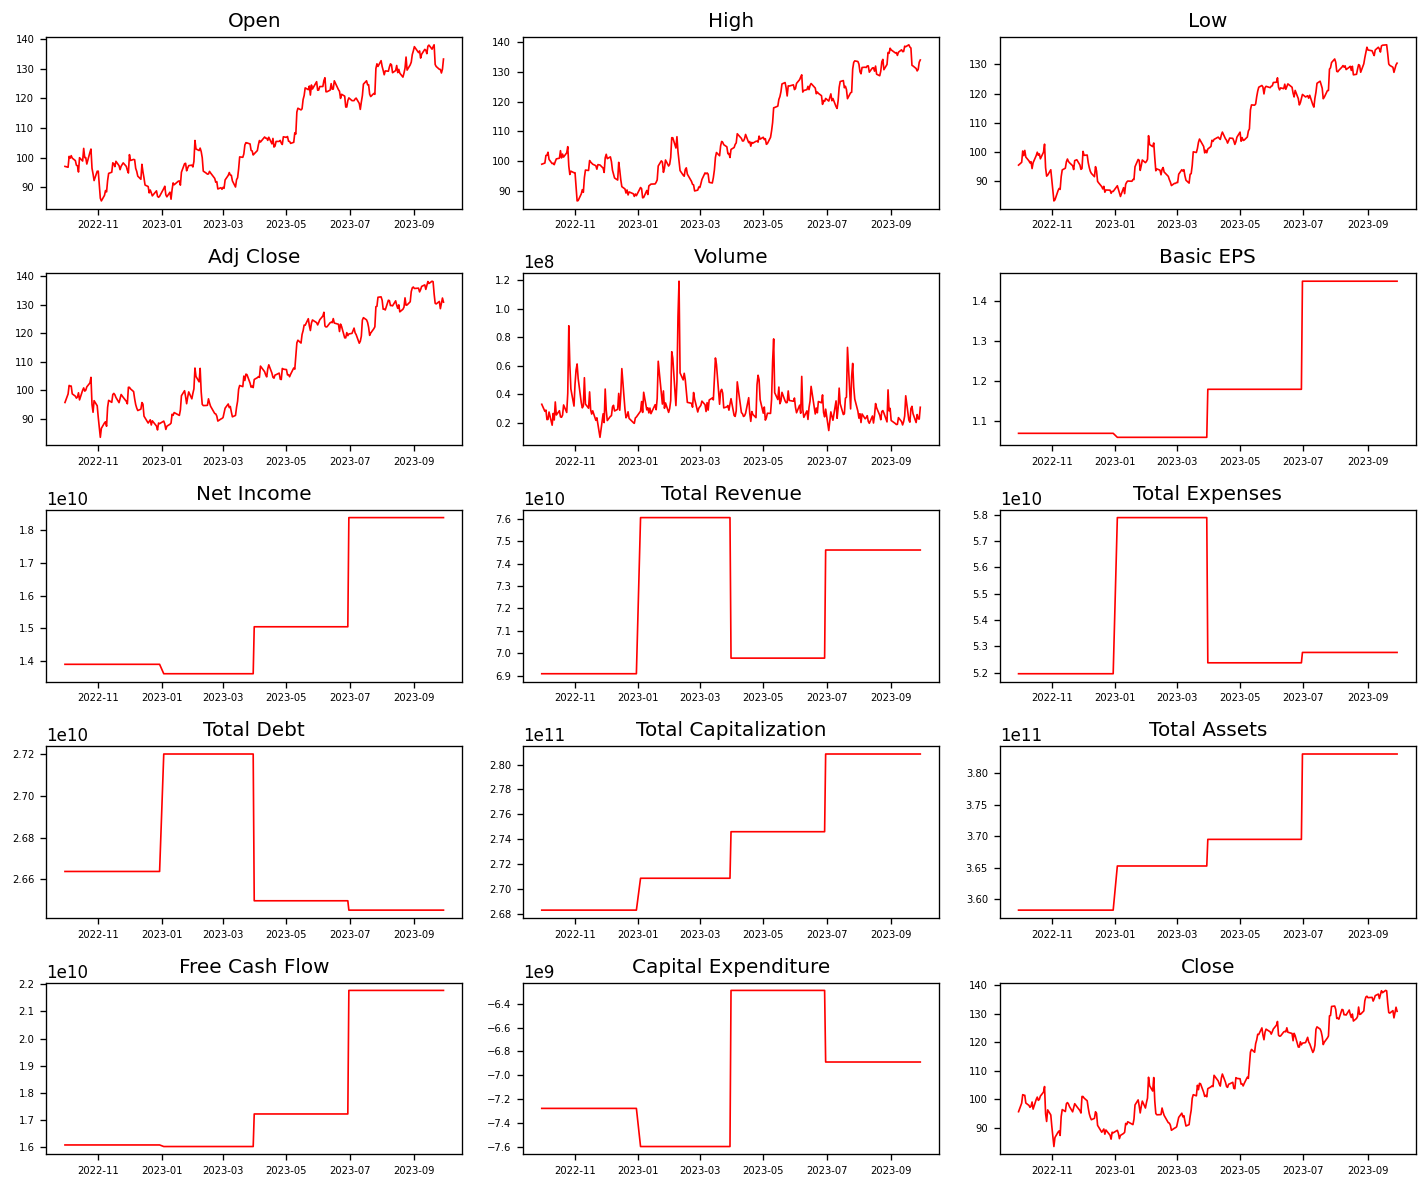

In [27]:
plot_columns(google_df)

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>,
        <Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Adj Close'}>],
       [<Axes: title={'center': 'Volume'}>,
        <Axes: title={'center': 'Basic EPS'}>,
        <Axes: title={'center': 'Net Income'}>,
        <Axes: title={'center': 'Total Revenue'}>],
       [<Axes: title={'center': 'Total Expenses'}>,
        <Axes: title={'center': 'Total Debt'}>,
        <Axes: title={'center': 'Total Capitalization'}>,
        <Axes: title={'center': 'Total Assets'}>],
       [<Axes: title={'center': 'Free Cash Flow'}>,
        <Axes: title={'center': 'Capital Expenditure'}>,
        <Axes: title={'center': 'Close'}>, <Axes: >]], dtype=object)

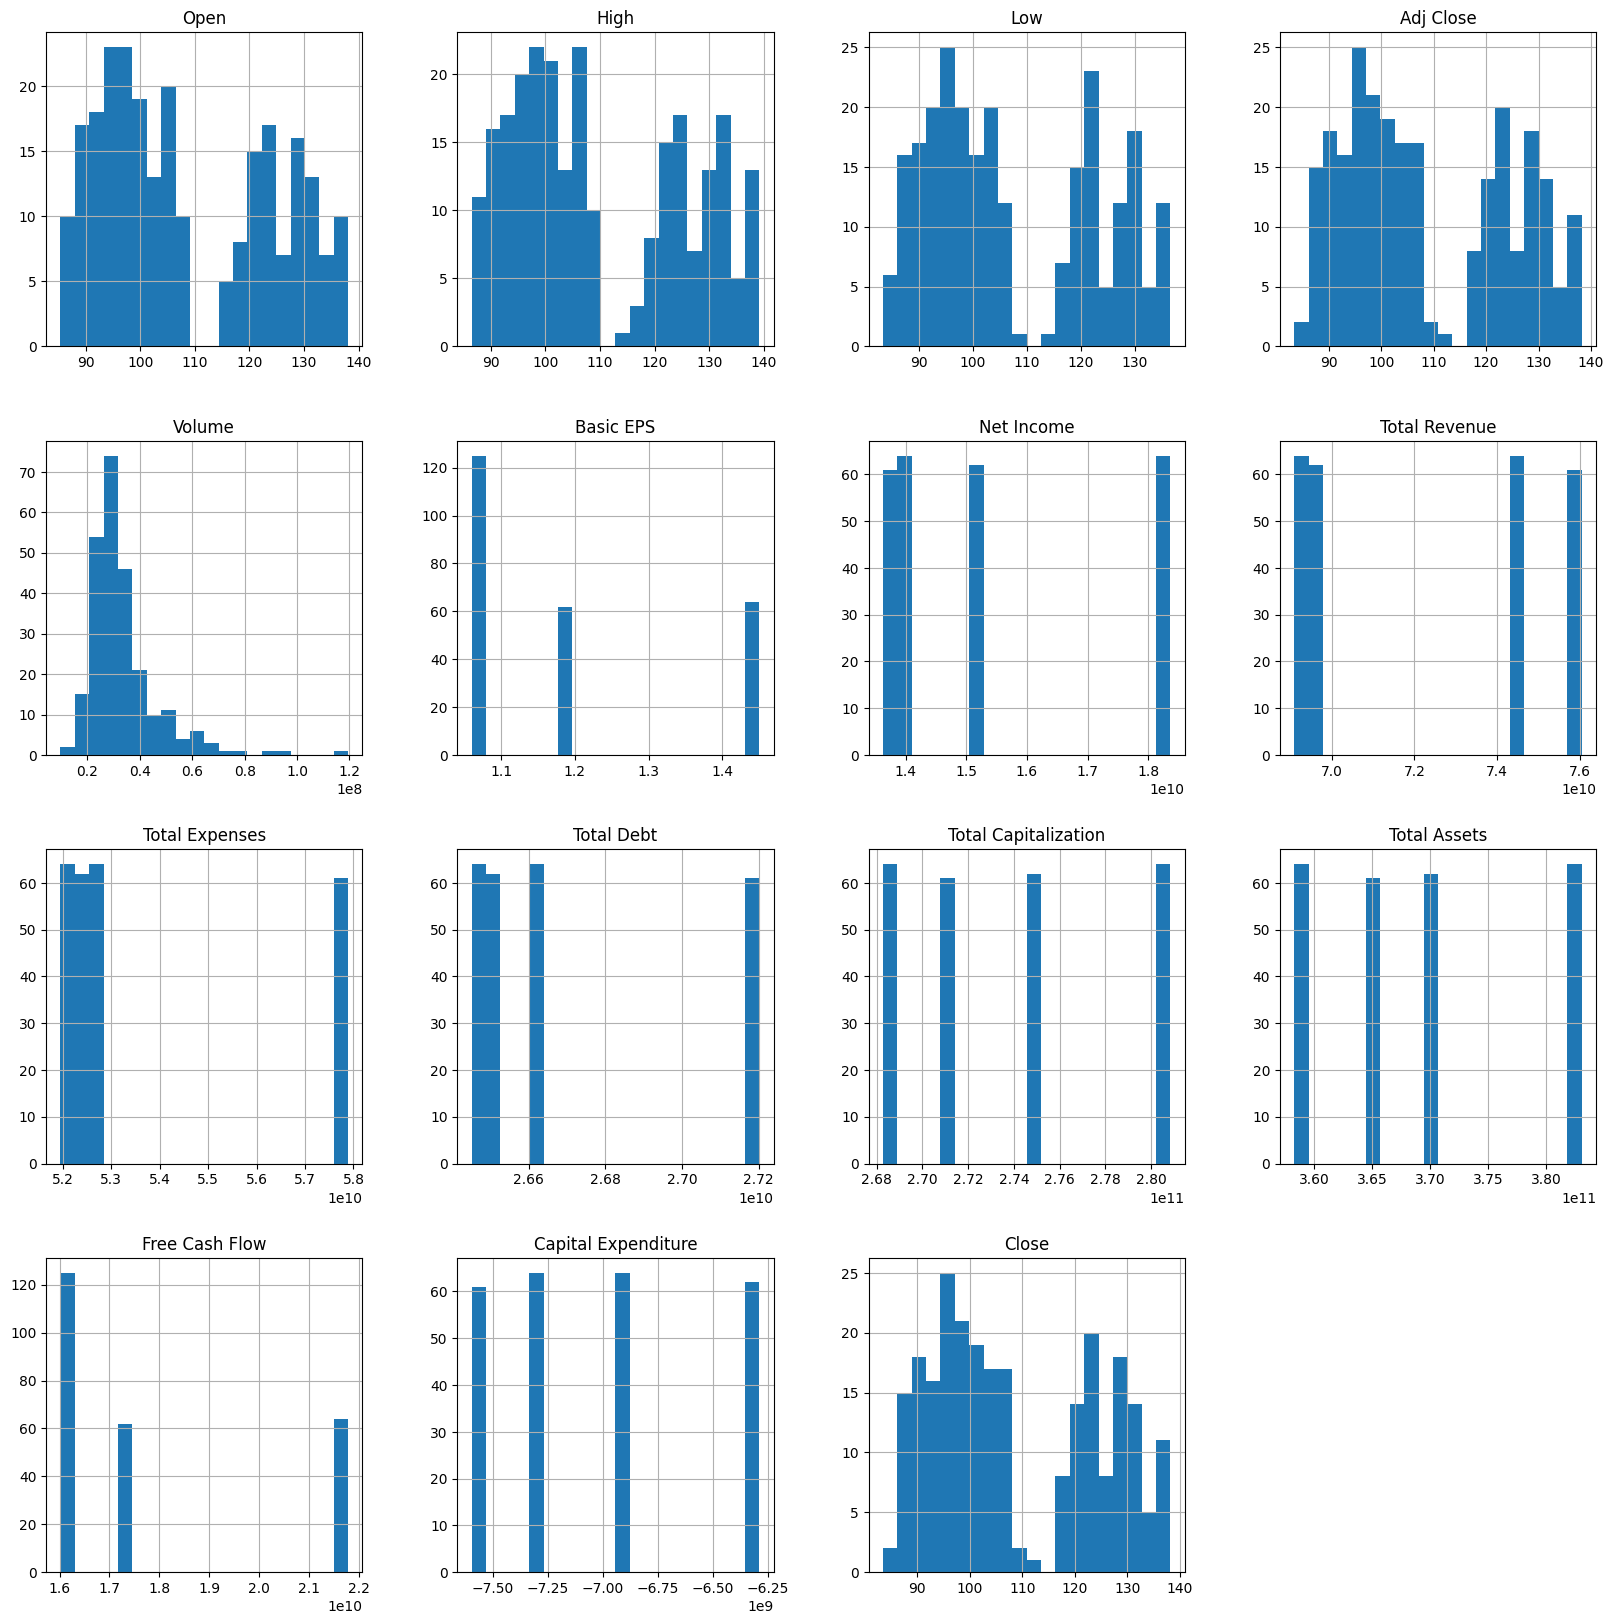

In [28]:
# Plot histograms for all the columns in the Google dataframe
google_df.hist(bins=20, figsize=(20, 20))

# Bivariate Analysis

## Granger’s Causality Test

In [29]:
# The rows of the output are the response variables, while the columns are the predoctors.
# The values are called P-Values, p-value < 0.05 means that X does not cause Y.
def granger_causation_matrix(data):    
    test = 'ssr_chi2test'
    verbose=False
    maxlag=12
    columns = data.columns
    df = pd.DataFrame(np.zeros((len(columns), len(columns))), columns=columns, index=columns)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in columns]
    df.index = [var + '_y' for var in columns]
    return df

granger_causation_matrix(google_df) 

c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\sta

,Open_x,High_x,Low_x,Adj Close_x,Volume_x,Basic EPS_x,Net Income_x,Total Revenue_x,Total Expenses_x,Total Debt_x,Total Capitalization_x,Total Assets_x,Free Cash Flow_x,Capital Expenditure_x,Close_x
Open_y,1.0000,0.0000,0.0000,0.0000,0.0543,0.0245,0.0360,0.3108,0.4042,0.4649,0.0026,0.0083,0.0605,0.2047,0.0000
High_y,0.0210,1.0000,0.0000,0.0000,0.1188,0.0339,0.0487,0.4840,0.5247,0.5528,0.0029,0.0092,0.0739,0.2575,0.0000
Low_y,0.0018,0.0041,1.0000,0.0000,0.2910,0.0535,0.0755,0.2498,0.4734,0.5620,0.0056,0.0089,0.1134,0.2196,0.0000
Adj Close_y,0.0297,0.1025,0.0049,1.0000,0.5335,0.0303,0.0436,0.4773,0.7308,0.6467,0.0034,0.0090,0.0659,0.2808,1.0000
Volume_y,0.0296,0.1081,0.0090,0.0981,1.0000,0.0271,0.0237,0.3095,0.0135,0.0084,0.0887,0.1527,0.0340,0.1833,0.0981
Basic EPS_y,0.0717,0.1061,0.0686,0.0399,0.4643,1.0000,0.1970,0.8864,0.9251,0.8555,0.1888,0.3557,0.2029,0.2405,0.0399
Net Income_y,0.0651,0.0953,0.0609,0.0353,0.4805,0.1812,1.0000,0.9101,0.9234,0.8314,0.1744,0.3123,0.3780,0.2256,0.0353
Total Revenue_y,0.1996,0.4301,0.2961,0.5648,0.5638,0.6048,0.5992,0.9999,0.5764,0.6090,0.6612,0.6553,0.5923,0.8600,0.5648
Total Expenses_y,0.1504,0.1673,0.1646,0.1761,0.9552,0.4909,0.5054,0.6106,1.0000,0.3659,0.4107,0.4273,0.5324,0.4022,0.1761
Total Debt_y,0.0584,0.0716,0.0650,0.0731,0.9639,0.3415,0.3664,0.3260,0.1793,1.0000,0.2260,0.2415,0.3962,0.3603,0.0731


# Multivariate Analysis

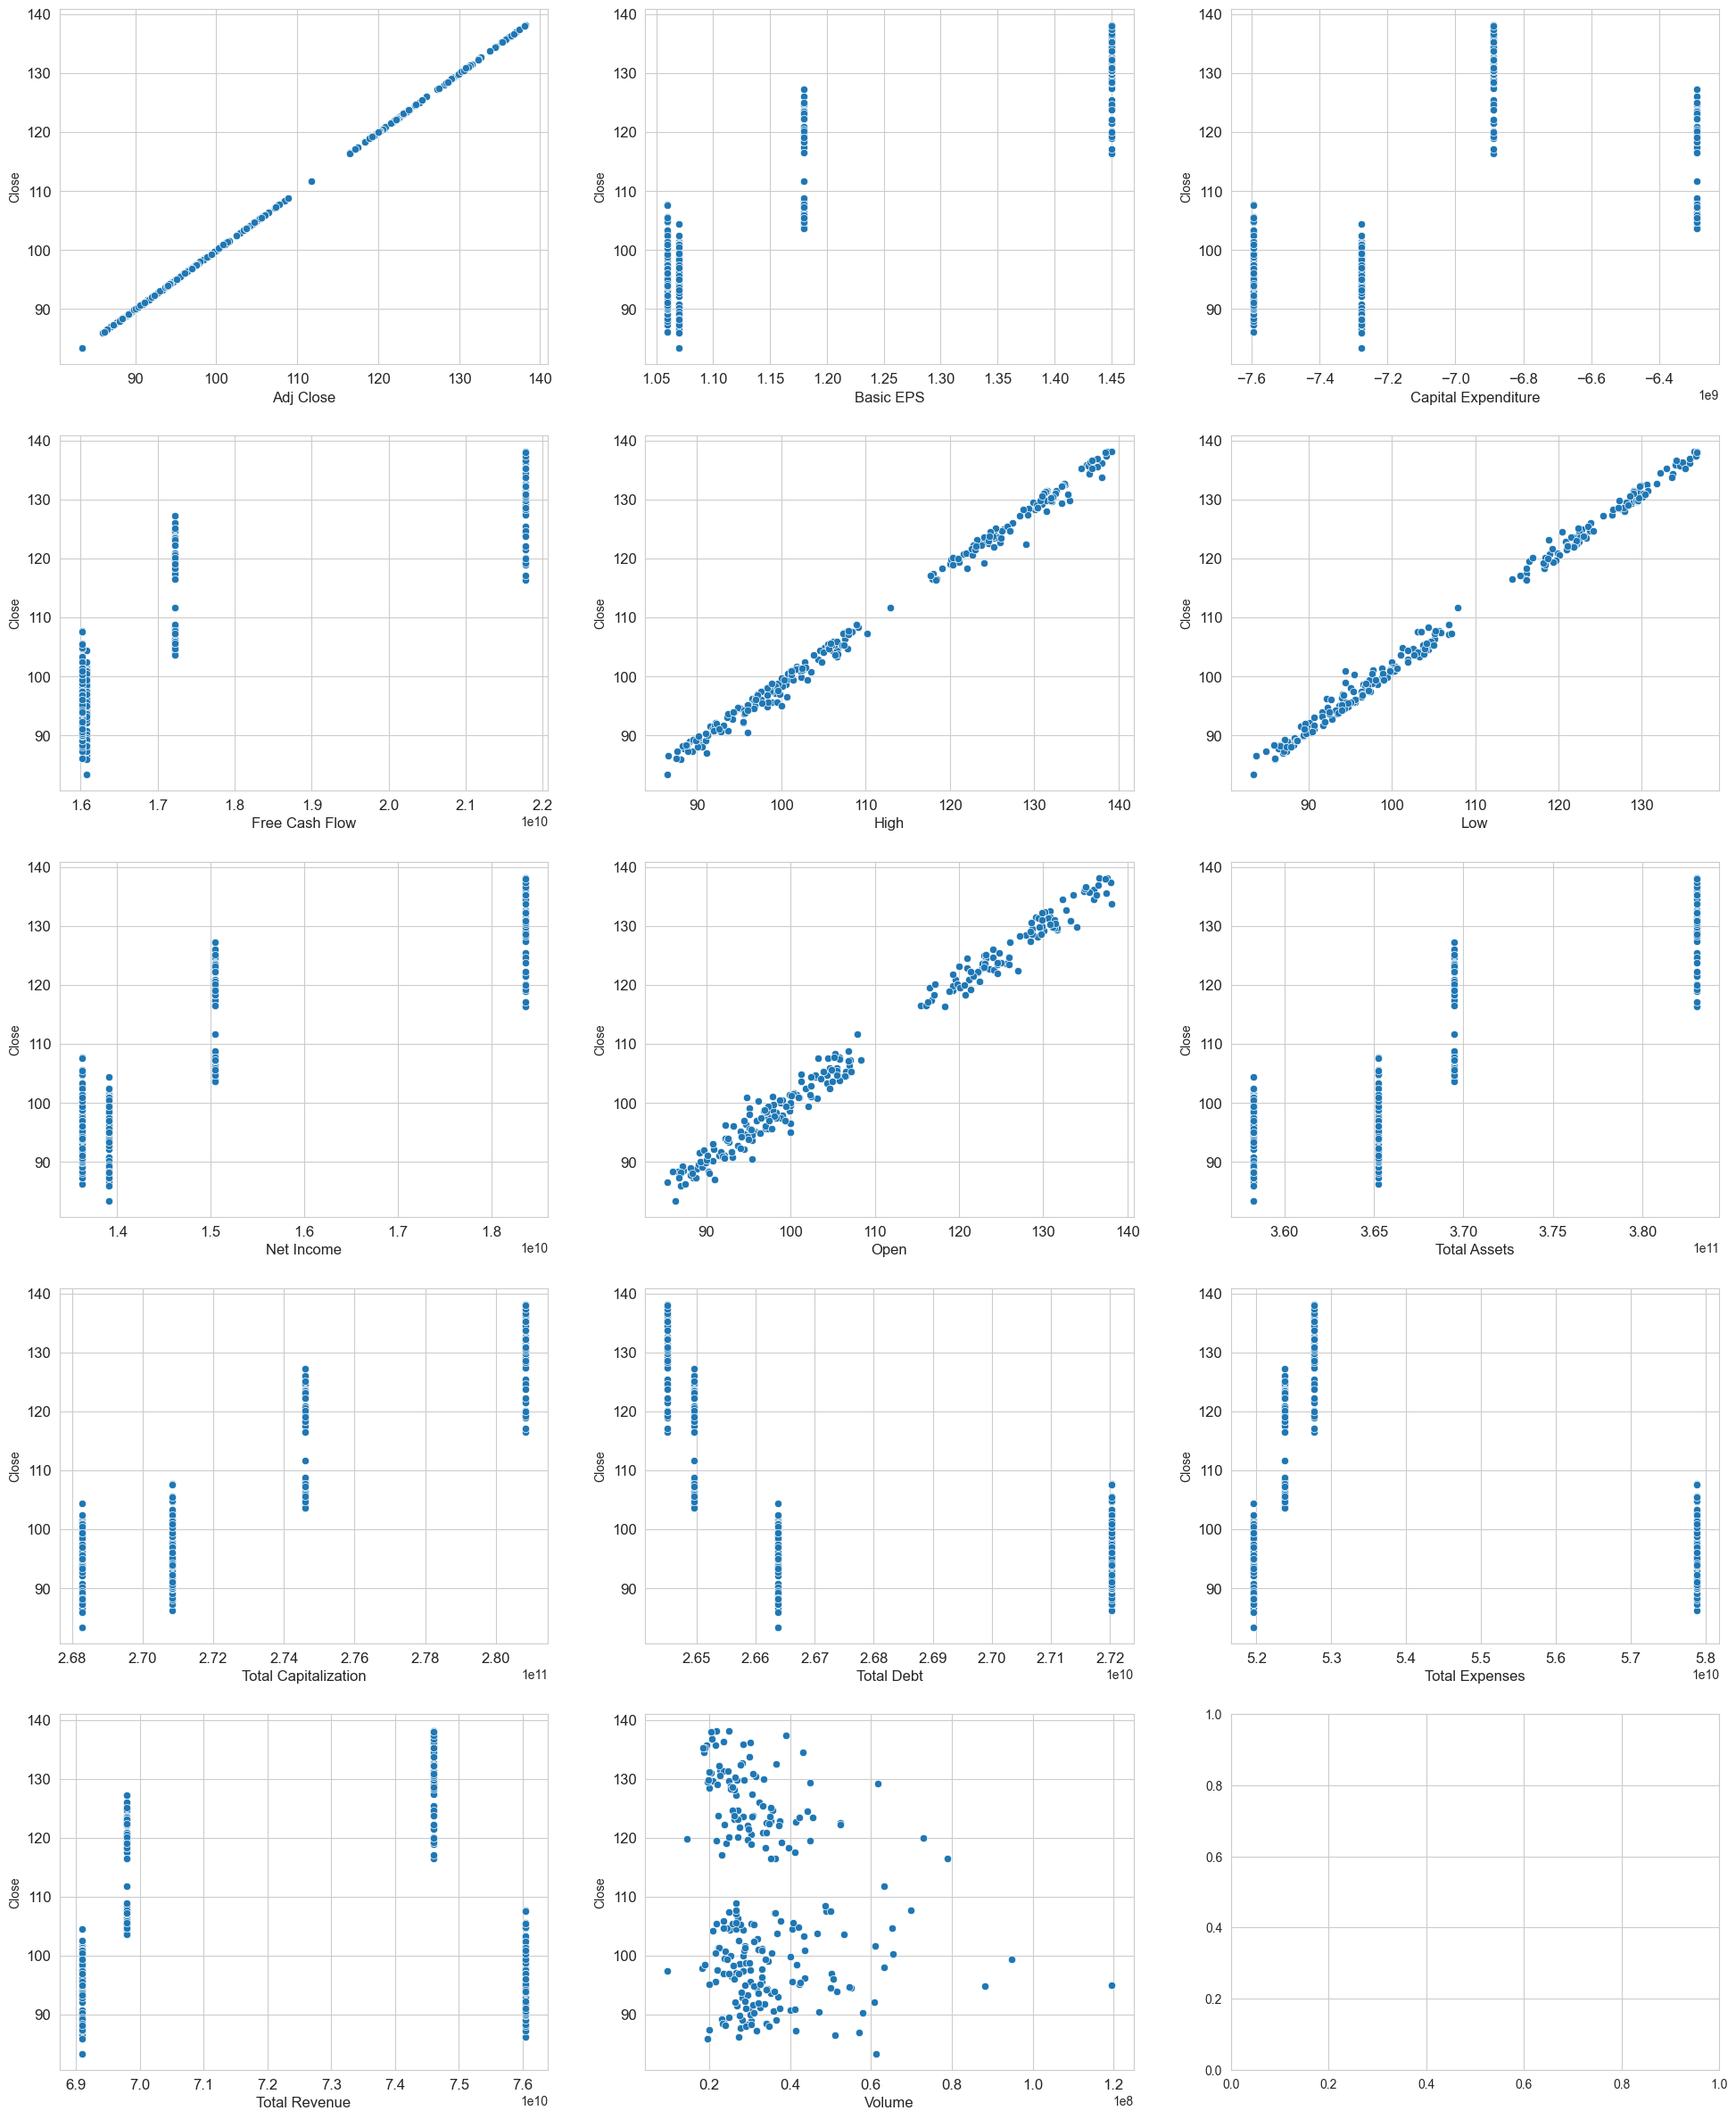

In [30]:
features = google_df.columns.difference(['Close']).values
i = 0
sns.set_style('whitegrid')
fig, ax = plt.subplots(5,3,figsize=(24,30))

for feature in features:
    i += 1
    plt.subplot(5,3,i)
    sns.scatterplot(x=feature, y='Close', data=google_df[[feature, 'Close']])
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

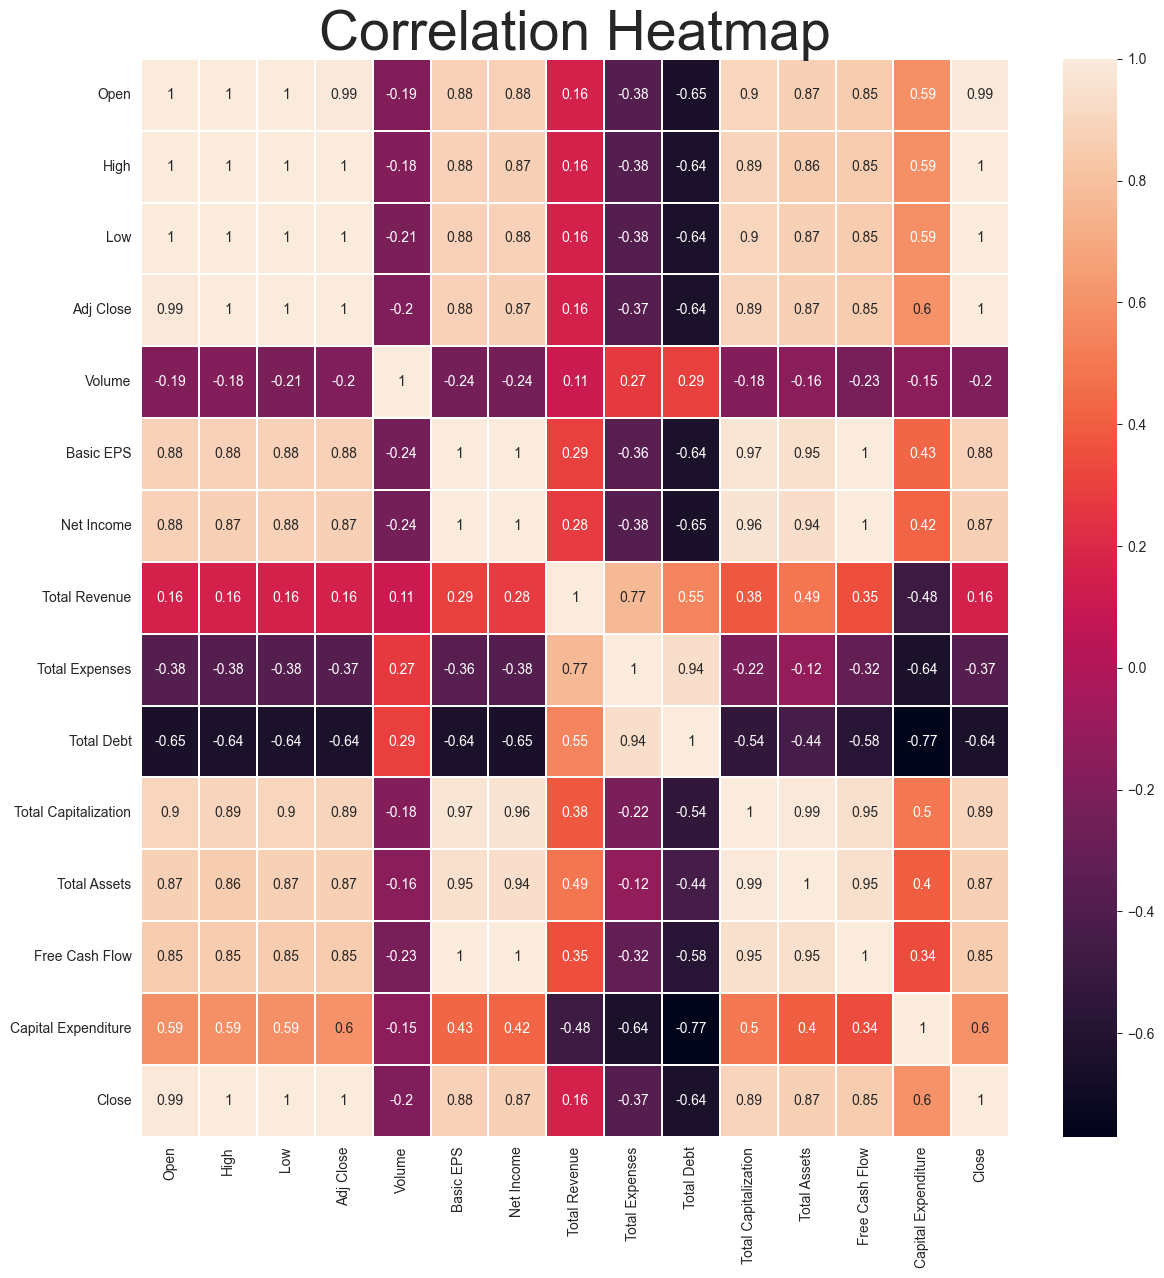

In [31]:
# Correlation between columns using Pearson method
corr = google_df.corr().round(2)
fig, ax = plt.subplots(figsize=(14,14))
s = sns.heatmap(corr, annot=True, linewidths=0.1, ax=ax)
s.set_title('Correlation Heatmap', fontsize=40)
plt.show()

# Check Null Values

In [32]:
print(sp500_df.isnull().sum())

Symbol                   0
Open                     0
High                     0
Low                      0
Adj Close                0
Volume                   0
Basic EPS                3
Net Income               0
Total Revenue            0
Total Expenses           0
Total Debt               0
Total Capitalization     0
Total Assets             0
Free Cash Flow           0
Capital Expenditure     62
Close                    0
dtype: int64


# Drop Null Values

In [33]:
sp500_df.dropna(inplace=True)

# Check Duplicates

In [34]:
sp500_df.duplicated().sum()

0

# Select a Stock From the S&P 500 stocks to Predict

In [35]:
selected_stock_df = sp500_df[sp500_df['Symbol'] == 'GOOGL']
selected_stock_df.drop(columns='Symbol', inplace=True)

C:\Users\Adham\AppData\Local\Temp\ipykernel_17608\3935005524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_stock_df.drop(columns='Symbol', inplace=True)


# Check If Data Is Stationary

In [36]:
def adfuller_test(series, column_name):
    significane_level = 0.05
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{column_name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {significane_level}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= significane_level:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [39]:
# ADF Test on each column
for name, column in google_df.items():
    adfuller_test(column, name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.6475
 No. Lags Chosen       = 0
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.8599. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.748
 No. Lags Chosen       = 1
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.8339. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root

# Make Data Stationary By Conducting Differencing

In [ ]:
df_differenced = selected_stock_df.diff().dropna()

In [221]:
# Re-run ADF Test on each column
for name, column in df_differenced.items():
    adfuller_test(column, name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.4317
 No. Lags Chosen       = 0
 Critical value 1%     = -3.464
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.6407
 No. Lags Chosen       = 0
 Critical value 1%     = -3.464
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

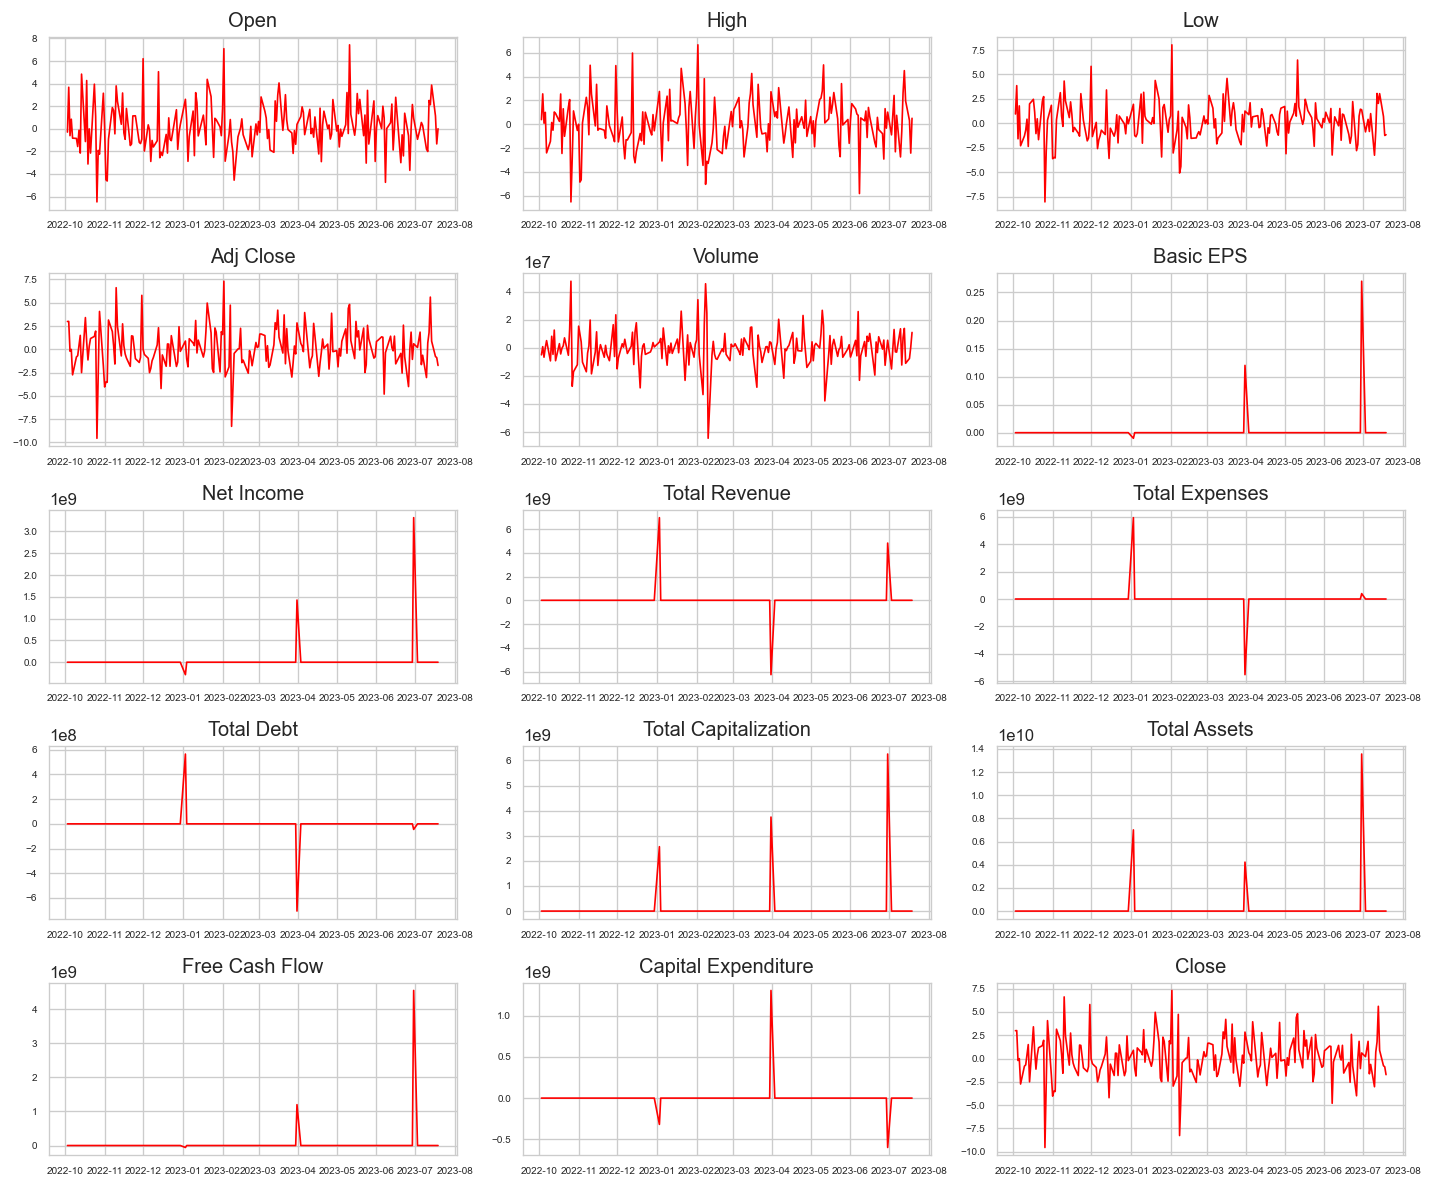

In [222]:
plot_columns(df_differenced)

# Split Data

In [45]:
X = selected_stock_df.drop(["Close"], axis=1)
y = selected_stock_df["Close"]

In [46]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, shuffle=False, random_state=42)

In [47]:
df_train = deepcopy(X_train)
df_train["Close"] = y_train

In [48]:
df_train.shape

(200, 15)

In [49]:
df_test = deepcopy(X_test)
df_test["Close"] = y_test

In [50]:
df_test.shape

(51, 15)

# Make Prediction

In [55]:
# Fit a VAR model
model = VAR(selected_stock_df)
results = model.fit()

c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [56]:
# Make predictions for the next 30 days
lag_order = results.k_ar
pred_values = results.forecast(selected_stock_df.values[-lag_order:], steps=30)

In [57]:
# Create a DataFrame with predicted values and maintain the date index
date_rng = pd.date_range(start=selected_stock_df.index[-1] + pd.DateOffset(1), periods=30, freq='D')
pred_df = pd.DataFrame(pred_values, index=date_rng, columns=selected_stock_df.columns)
pred_df

,Open,High,Low,Adj Close,Volume,Basic EPS,Net Income,Total Revenue,Total Expenses,Total Debt,Total Capitalization,Total Assets,Free Cash Flow,Capital Expenditure,Close
2023-09-30,131.085949,132.354461,129.585687,130.779341,3.073253e+07,1.449688,1.836591e+10,7.454689e+10,5.271951e+10,2.644704e+10,2.808086e+11,3.829575e+11,2.177357e+10,-6.887593e+09,130.779347
2023-10-01,130.899323,132.299795,129.583848,130.797149,2.945794e+07,1.449971,1.836969e+10,7.452754e+10,5.270096e+10,2.644504e+10,2.808100e+11,3.829534e+11,2.177723e+10,-6.885824e+09,130.797155
2023-10-02,130.900441,132.321345,129.609137,130.841749,2.891234e+07,1.450184,1.837258e+10,7.451555e+10,5.268865e+10,2.644375e+10,2.808105e+11,3.829504e+11,2.178030e+10,-6.885059e+09,130.841756
2023-10-03,130.938414,132.358076,129.652880,130.885328,2.863915e+07,1.450396,1.837542e+10,7.450507e+10,5.267753e+10,2.644258e+10,2.808113e+11,3.829485e+11,2.178342e+10,-6.884447e+09,130.885334
2023-10-04,130.978686,132.396936,129.695049,130.926625,2.848864e+07,1.450624,1.837846e+10,7.449512e+10,5.266664e+10,2.644143e+10,2.808126e+11,3.829477e+11,2.178680e+10,-6.883867e+09,130.926631
2023-10-05,131.017996,132.435297,129.734835,130.965606,2.840140e+07,1.450861,1.838160e+10,7.448551e+10,5.265592e+10,2.644029e+10,2.808142e+11,3.829475e+11,2.179034e+10,-6.883315e+09,130.965612
2023-10-06,131.055686,132.472339,129.772340,131.002383,2.834697e+07,1.451103,1.838480e+10,7.447616e+10,5.264535e+10,2.643916e+10,2.808159e+11,3.829477e+11,2.179397e+10,-6.882790e+09,131.002389
2023-10-07,131.091571,132.507737,129.807721,131.037085,2.830963e+07,1.451346,1.838802e+10,7.446703e+10,5.263491e+10,2.643805e+10,2.808177e+11,3.829481e+11,2.179763e+10,-6.882293e+09,131.037091
2023-10-08,131.125624,132.541385,129.841120,131.069838,2.828121e+07,1.451590,1.839124e+10,7.445810e+10,5.262463e+10,2.643695e+10,2.808195e+11,3.829486e+11,2.180132e+10,-6.881825e+09,131.069844
2023-10-09,131.157888,132.573283,129.872667,131.100762,2.825751e+07,1.451832,1.839444e+10,7.444937e+10,5.261450e+10,2.643588e+10,2.808213e+11,3.829492e+11,2.180500e+10,-6.881386e+09,131.100768


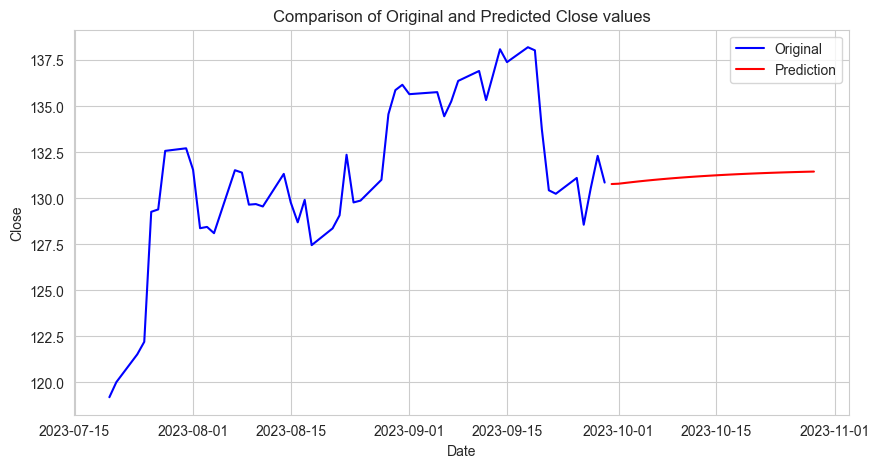

In [66]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_test.index, df_test['Close'], label='Original', color='blue')
plt.plot(pred_df.index, pred_df['Close'], label='Prediction', color='red')

# Customize the plot
plt.title('Comparison of Original and Predicted Close values')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()

# Show the plot
plt.show()